In [148]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (13, 20)})

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [150]:
from utils import read_pdf, parser_model
from nlp import topic

In [151]:
with open("data/urls-st.txt", "r") as file:
    urls = file.read().split("\n")
    
for url in urls:
    if not read_pdf.is_url(url):
        print(f"Not an url: {url}")

Not an url: https://www.blackrock.com/corporate/literature/publication/blk-annual-stewardship-report-2020.pdf 


In [152]:
urls = {
    "CTF": 'https://assets.ctfassets.net/y4nxuejkhx03/6Pc2JwL0iwK5rGgQQ0BRJb/1eb987ec52a1f37a04dc74aaecd00c32/NN-IP-Stewardship-Policy_Feb2020.pdf',
    "APG": 'https://apg.nl/media/x5dbnvs2/apg-responsible-investment-stewardship-policy-final_eng.pdf',
    "DWS": 'https://www.dws.com/contentassets/5e4ab67003474a23bfe54316e5420c42/dbg168418-esg-statement_r3.pdf',
    "JPMorgan": 'https://am.jpmorgan.com/blob-gim/1383664293468/83456/J.P.%20Morgan%20Asset%20Management%20investment%20stewardship%20statement.pdf'
}

In [153]:
data = pd.DataFrame(urls, index=["Url", "Metric", "Contribution"])

In [154]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [155]:
keywords = set(["climate", "change", "environment", "sustainable"])

def find_keywords(df):
    
    df = df.sort_values("Dominant_Topic").reset_index(drop = True)
    
    impact_factor = 0.
    contr = 0.
    
    for row, kwds in enumerate(df["Keywords"]):
        
        found = False
        
        for k in kwds.split(', '):
            if k in keywords:
                found = True
                
        if found:
            impact_factor += df["Dominant_Topic"][row]
            contr += df["Topic_Perc_Contrib"][row]

        found = False
        
    return impact_factor / sum(df["Dominant_Topic"]), np.mean(contr)

In [156]:
def plot_bigrams(sentences, ax, n = 10):
    bigram_tf_idf_vectorizer = TfidfVectorizer(ngram_range=(2,2), use_idf=True)
    bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform([" ".join(sent) for sent in sentences])
    
    words = bigram_tf_idf_vectorizer.get_feature_names()
    
    total_counts = np.zeros(len(words))
    for t in bigram_tf_idf:
        total_counts += t.toarray()[0]
        
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
        
    sns.barplot(x_pos, counts, palette="Blues_r", ax = ax)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(words, rotation = 45)
    
    ax.set_xlabel("Bi-grams")


Working on company  CTF


Working on company  APG


Working on company  DWS


Working on company  JPMorgan


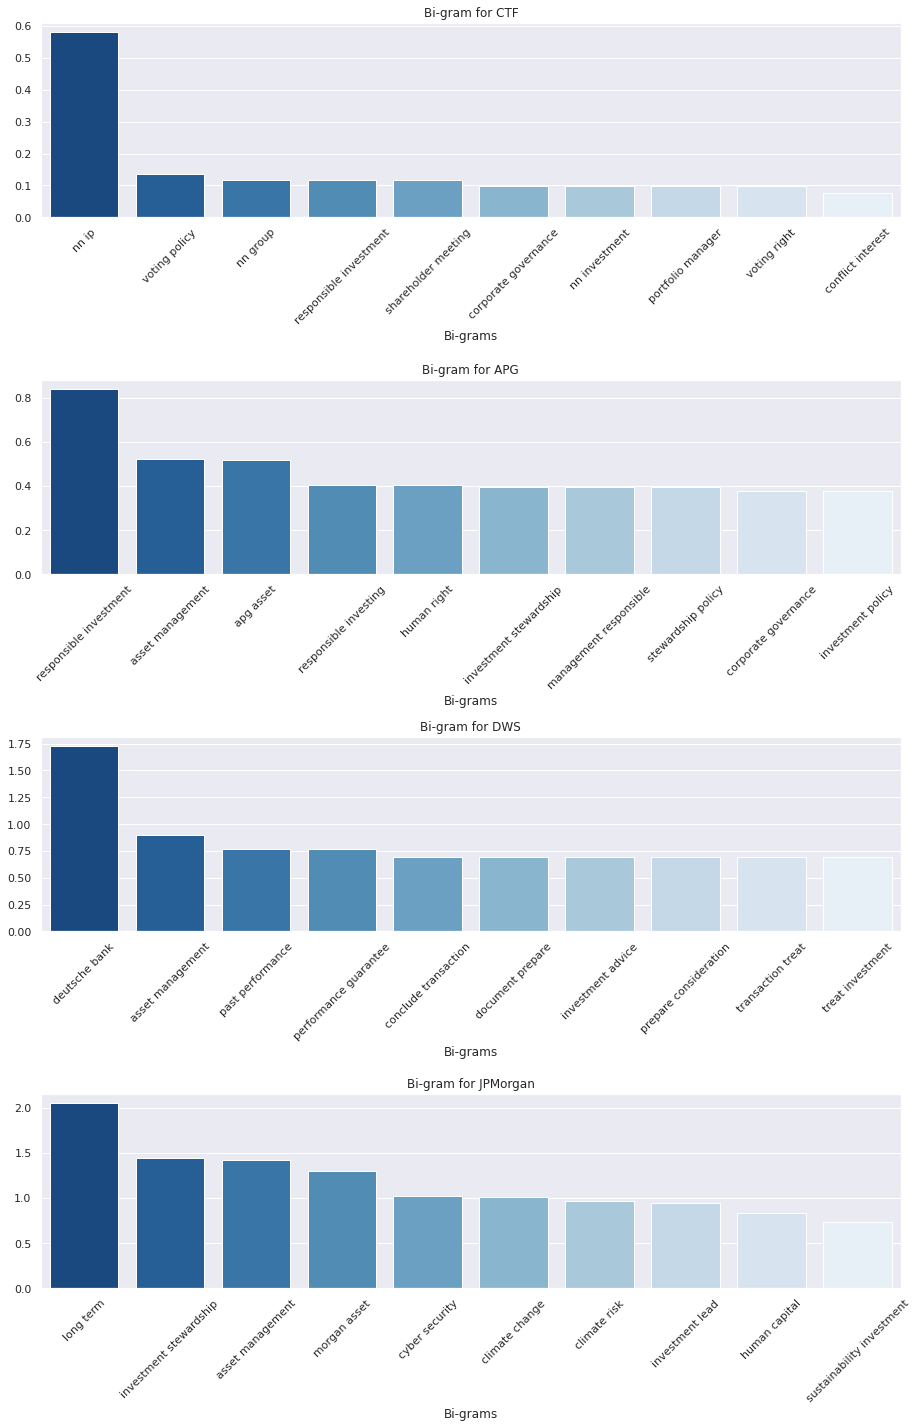

In [162]:
fig, axes = plt.subplots(nrows=len(urls.keys()), ncols=1)

for i, (company, url) in enumerate(urls.items()):
        
    print("Working on company ", company)
    
    text = read_pdf.path_to_sentences(url)
    model, corpus, sentences = topic.get_topics(text, num_topics = 50)
    df_topic_sents_keywords = format_topics_sentences(model, corpus, sentences)

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    df_dominant_topic.sort_values("Dominant_Topic", ascending=False).head()
    
    metric, contr = find_keywords(df_dominant_topic)
    
    data.loc["Metric", company] = metric * 100
    data.loc["Contribution", company] = contr

    
    plot_bigrams(sentences, ax = axes[i])
    
    axes[i].set_title(f"Bi-gram for {company}")
    
fig.tight_layout()
fig.show()

In [163]:
data

,CTF,APG,DWS,JPMorgan
Url,https://assets.ctfassets.net/y4nxuejkhx03/6Pc2...,https://apg.nl/media/x5dbnvs2/apg-responsible-...,https://www.dws.com/contentassets/5e4ab6700347...,https://am.jpmorgan.com/blob-gim/1383664293468...
Metric,0,11.7424,6.55977,31.6254
Contribution,0,0.9966,0.8949,12.4186
